In [81]:
from datetime import datetime
import json
from utils import load_all_llm_answers_from_json
import pandas as pd

In [268]:
answers_save_path = './2024-06-21-Multi-Benchmark (temp=0)/auto_eval_outputs'

all_llm_answers = load_all_llm_answers_from_json(answers_save_path, prefix_replace='auto_eval-')

all_llm_answers

{'claude-3-5-sonnet-20240620':      level_0  index         category  \
 0          0      1           Puzzle   
 1          1      2           Puzzle   
 2          2      3          Spatial   
 3          3      4           Puzzle   
 4          4      5           Puzzle   
 ..       ...    ...              ...   
 295      295     26           Puzzle   
 296      296     27           Puzzle   
 297      297     28  Popular science   
 298      298     29       Relational   
 299      299     30  Popular science   
 
                                               question  \
 0    You have six horses and want to race them to s...   
 1    Suppose you're on a game show, and you're give...   
 2    You are playing Russian roulette with a six-sh...   
 3    A farmer wants to cross a river and take with ...   
 4    Bob has three boxes in front of him - Box A, B...   
 ..                                                 ...   
 295  A runaway trolley is heading down the tracks a...   
 296

In [269]:
all_llm_answers[list(all_llm_answers.keys())[0]].head(1)

,level_0,index,category,question,human_answer,correct_answer,multiple_choice,multi_choice_question,correct_letter,model_answer,score,json_answer,json_answer_letter,invalid_answer_letter
0,0,1,Puzzle,You have six horses and want to race them to s...,Race them on a single race track with at least...,One,"[One, Three, Unknown, Two]",QUESTION\n You have six horses and want to ...,A,Let's think through this step-by-step:\n\n1. W...,0,{'ANSWER': 'D'},D,0


In [274]:
# # Sanity check to see if the scores are being calculated correctly in the below cells after a low of manipulation
# model_scores = []
# for llm_model in list(all_llm_answers.keys()):
#     correct_answer = all_llm_answers[llm_model]['correct_letter'] == all_llm_answers[llm_model]['json_answer_letter']
#     percentage_correct = correct_answer.value_counts(normalize=True)[True] * 100
#     initial_score = all_llm_answers[llm_model]['score'].mean()
#     dict_results = {
#         'model': llm_model,
#         'percentage_correct': percentage_correct,
#         'initial_score': initial_score
#     }
#     model_scores.append(dict_results)

# model_scores_series = pd.DataFrame(model_scores).sort_values(by='percentage_correct', ascending=False)
# model_scores_series

In [238]:
moe_llm_answers = {}
for llm_model in list(all_llm_answers.keys()):
    answer_subset = all_llm_answers[llm_model]
    data = answer_subset[[
        'index', 'question', 'multiple_choice', 'correct_answer',
        'multi_choice_question', 'correct_letter', 'json_answer_letter',
    ]]
    moe_llm_answers[llm_model] = []
    for idx, row in data.iterrows():
        # if idx > 0:
        #     continue
        normalized_choices_dict_inv = dict(zip(sorted(row['multiple_choice']), ['A', 'B', 'C', 'D']))
        presented_choices_dict = dict(zip(['A', 'B', 'C', 'D'], row['multiple_choice']))
        correct_answer = presented_choices_dict[row['correct_letter']]
        assert(row['correct_answer'] == correct_answer)
        normalized_correct_letter = normalized_choices_dict_inv[correct_answer]
        if row['json_answer_letter'] not in presented_choices_dict:
            selected_answer, normalized_choice_letter = None, None
        else:
            selected_answer = presented_choices_dict[row['json_answer_letter']]
            normalized_choice_letter = normalized_choices_dict_inv[selected_answer]
        moe_llm_answers[llm_model].append({
            'question': row['question'],
            # 'selected_answer': selected_answer,
            # 'correct_answer': correct_answer,
            'normalized_correct_letter': normalized_correct_letter,
            'normalized_choice_letter': normalized_choice_letter,
        })
        #print(f"idx: {idx} | {llm_model} | {moe_llm_answers[llm_model]}\n")

In [239]:
moe_llm_answers_comb_df = {}
for llm_model in list(all_llm_answers.keys()):
    data = pd.DataFrame(moe_llm_answers[llm_model])
    data.reset_index(drop=False, inplace=True)
    columns_mapping = {
        'index': ('bench', 'index'),
        'question': ('bench', 'question'),
        'normalized_correct_letter': ('bench', 'normalized_correct_letter'),
        'normalized_choice_letter': (llm_model, 'normalized_choice_letter')
    }
    grouped_columns_map = [columns_mapping[col] for col in data.columns if col in columns_mapping]
    grouped_columns = pd.MultiIndex.from_tuples(grouped_columns_map)
    data.columns = grouped_columns
    data
    if len(moe_llm_answers_comb_df) == 0:
        moe_llm_answers_comb_df = data
    else:
        moe_llm_answers_comb_df = pd.merge(moe_llm_answers_comb_df, data, on=[
            ('bench', 'index'), ('bench', 'question'), ('bench', 'normalized_correct_letter')
        ])

assert len(moe_llm_answers_comb_df) == len(all_llm_answers[list(all_llm_answers.keys())[0]]), 'Unable to reliably merge based on index, question, and normalized_correct_letter. This might suggest that the data is inconsistent or inaccurate'

moe_llm_answers_comb_df

bench                                                     \
    index                                           question   
0       0  You have six horses and want to race them to s...   
1       1  Suppose you're on a game show, and you're give...   
2       2  You are playing Russian roulette with a six-sh...   
3       3  A farmer wants to cross a river and take with ...   
4       4  Bob has three boxes in front of him - Box A, B...   
..    ...                                                ...   
295   295  A runaway trolley is heading down the tracks a...   
296   296  How do you efficiently measure exactly 4 gallo...   
297   297  A 2kg tree grows in a planted pot with 10kg of...   
298   298  A man steps over a 0.5m hurdle. What is the mi...   
299   299  I walk to my friend's house, averaging 3mph. H...   

                              claude-3-5-sonnet-20240620  \
    normalized_correct_letter   normalized_choice_letter   
0                           A                          C   
1                           D                          B   
2                           D                          D   
3                           B                          C   
4                           A                          A   
..                        ...                        ...   
295                         A                          A   
296                         A                          A   
297                         A                          D   
298                         B                          D   
299                         D                          D   

      claude-3-opus-20240229                command-r  \
    normalized_choice_letter normalized_choice_letter   
0                          B                        C   
1                          B                        C   
2                          D                        B   
3                          C                        B   
4                          C                        A   
..                       ...                      ...   
295                        B                        D   
296                        A                        A   
297                        D                        D   
298                        D                        A   
299                        D                        C   

              gemini-1_0-pro           gemini-1_5-pro  \
    normalized_choice_letter normalized_choice_letter   
0                          B                        C   
1                          B                        B   
2                          D                        B   
3                          D                        C   
4                          A                        A   
..                       ...                      ...   
295                        D                        B   
296                        C                        B   
297                        A                        A   
298                        D                        D   
299                        C                        D   

         gpt-4-turbo-preview                   gpt-4o  \
    normalized_choice_letter normalized_choice_letter   
0                          A                        A   
1                          B                        B   
2                          B                        D   
3                          C                        C   
4                          C                        C   
..                       ...                      ...   
295                        B                        B   
296                        D                        A   
297                        A                        A   
298                        D                        D   
299                        D                        D   

    meta_llama3-70b-instruct-v1_0     mistral-large-latest  \
         normalized_choice_letter normalized_choice_letter   
0                               B       

In [240]:
llm_models = list(all_llm_answers.keys())
norm_choice_cols = list(zip(llm_models, ['normalized_choice_letter'] * len(llm_models)))
norm_choice_cols

[('claude-3-5-sonnet-20240620', 'normalized_choice_letter'),
 ('claude-3-opus-20240229', 'normalized_choice_letter'),
 ('command-r', 'normalized_choice_letter'),
 ('gemini-1_0-pro', 'normalized_choice_letter'),
 ('gemini-1_5-pro', 'normalized_choice_letter'),
 ('gpt-4-turbo-preview', 'normalized_choice_letter'),
 ('gpt-4o', 'normalized_choice_letter'),
 ('meta_llama3-70b-instruct-v1_0', 'normalized_choice_letter'),
 ('mistral-large-latest', 'normalized_choice_letter'),
 ('open-mixtral-8x22b', 'normalized_choice_letter')]

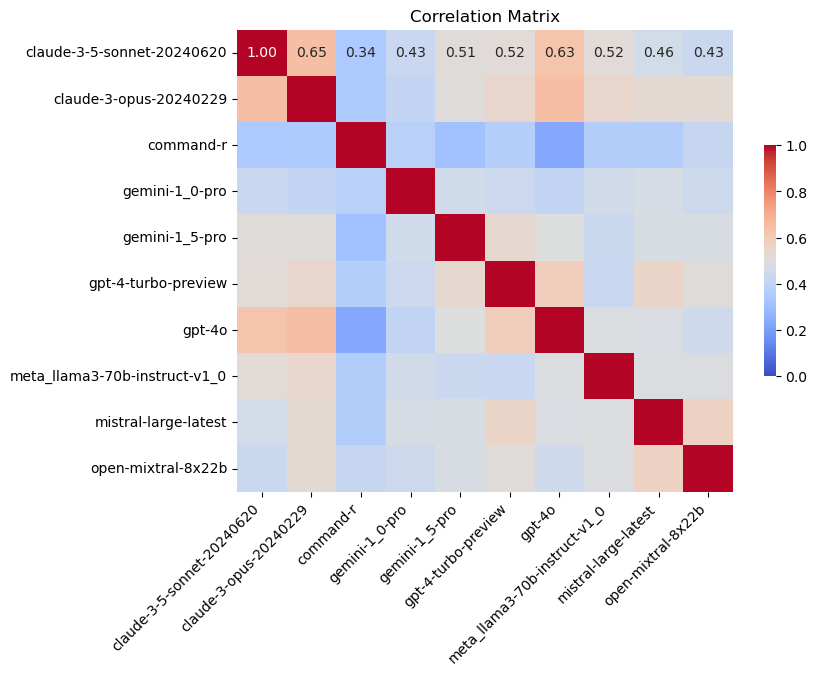

In [436]:
import seaborn as sns
import matplotlib.pyplot as plt

answer_correlations = {}
for (model_base, col) in norm_choice_cols:
    model_correlations = {}
    for (model_test, col) in norm_choice_cols:
        same_answer_percentage = ((moe_llm_answers_comb_df[model_base].fillna(0) 
                                   == moe_llm_answers_comb_df[model_test].fillna(0))
                                  .value_counts(normalize=True)[True])
        model_correlations[model_test] = same_answer_percentage
    answer_correlations[model_base] = model_correlations

correlation_matrix = pd.DataFrame(answer_correlations)

plt.figure(figsize=(8, 6))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1, 
                 cbar_kws={"shrink": 0.5}, fmt='.2f')
plt.xticks(rotation=45, ha='right')
plt.title('Correlation Matrix')
plt.show()

### Run test to see how MOE performs with various permutations of models

In [277]:
# Sanity check to see if model scores match those calculated earlier (because we have done a lot of messing about). 
# It can used as a basis to see if MOE is improving results or not.
result_series = pd.Series({col[0]: (moe_llm_answers_comb_df[col] == moe_llm_answers_comb_df['bench']['normalized_correct_letter']).value_counts(normalize=True)[True] 
 for col in norm_choice_cols})

result_series.sort_values(ascending=False)

claude-3-5-sonnet-20240620       0.496667
gpt-4o                           0.440000
claude-3-opus-20240229           0.430000
gpt-4-turbo-preview              0.350000
gemini-1_5-pro                   0.313333
open-mixtral-8x22b               0.313333
meta_llama3-70b-instruct-v1_0    0.293333
mistral-large-latest             0.286667
command-r                        0.250000
gemini-1_0-pro                   0.213333
dtype: float64

In [347]:
import numpy as np

def get_most_common_or_random(row):
    # Get the value counts for the row, if all NaNs, return a random choice
    value_counts = row.value_counts()
    if value_counts.empty:  # Check if value_counts is empty (all values are NaN)
        return np.random.choice(['A', 'B', 'C', 'D'])
    else:
        # Find the maximum count
        max_count = value_counts.max()
        # Find the indices (letters) that have the maximum count
        most_common_choices = value_counts[value_counts == max_count].index.tolist()
        # If there's more than one most frequent letter, pick one randomly
        return np.random.choice(most_common_choices)

In [368]:
subset_norm_choice_cols = [col for col in norm_choice_cols if col[0] in [
                            "claude-3-5-sonnet-20240620",
                            "gpt-4o",
                            "claude-3-opus-20240229",
                            "gpt-4-turbo-preview",
                            "gemini-1_5-pro",
                            "open-mixtral-8x22b",
                            "meta_llama3-70b-instruct-v1_0"
                           ]]

In [375]:
answer_values = moe_llm_answers_comb_df.apply(axis='columns', 
    func=lambda x: x[norm_choice_cols].value_counts())
most_common_answer = moe_llm_answers_comb_df.apply(axis='columns', 
    func=lambda x: get_most_common_or_random(x[norm_choice_cols]), result_type='expand')
answer_values['correct_letter'] = moe_llm_answers_comb_df['bench']['normalized_correct_letter']
answer_values['most_common_answer'] = most_common_answer
answer_values

,A,B,C,D,correct_letter,most_common_answer
0,2.0,4.0,3.0,1.0,A,B
1,NaN,9.0,1.0,NaN,D,B
2,1.0,3.0,NaN,6.0,D,D
3,2.0,1.0,5.0,2.0,B,C
4,5.0,NaN,5.0,NaN,A,C
...,...,...,...,...,...,...
295,1.0,7.0,NaN,2.0,A,B
296,6.0,1.0,2.0,1.0,A,A
297,5.0,NaN,NaN,5.0,A,A
298,1.0,1.0,NaN,8.0,B,D


In [376]:
(answer_values['correct_letter'] == answer_values['most_common_answer']).sum() / len(answer_values)

0.41333333333333333